<a href="https://colab.research.google.com/github/0raghad/churn/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# churn

Use the "Run" button to execute the code.

In [1]:
pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/blastchar/telco-customer-churn'
od.download(dataset_url)

Skipping, found downloaded files in "./telco-customer-churn" (use force=True to force download)


In [3]:
import pandas as pd
import numpy as np
#vis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
#scaling
from sklearn.preprocessing import StandardScaler

# oversampling
from imblearn.combine import SMOTEENN 

# train test split
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve


# model evaluation & tuning hyperparameter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

import math

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import itertools

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
df = pd.read_csv("/content/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis and Data Cleaning

In [6]:
df.drop(columns='customerID', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


we can see that the `TotalCharges` have the wrong data type so we will change it to numeric data type.


In [8]:
# Object values
for x in df.columns:
   if df[x].dtype == 'object':
      print(x, ': ',df[x]. nunique(),' unique values : ',df[x].unique())

gender :  2  unique values :  ['Female' 'Male']
Partner :  2  unique values :  ['Yes' 'No']
Dependents :  2  unique values :  ['No' 'Yes']
PhoneService :  2  unique values :  ['No' 'Yes']
MultipleLines :  3  unique values :  ['No phone service' 'No' 'Yes']
InternetService :  3  unique values :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  3  unique values :  ['No' 'Yes' 'No internet service']
OnlineBackup :  3  unique values :  ['Yes' 'No' 'No internet service']
DeviceProtection :  3  unique values :  ['No' 'Yes' 'No internet service']
TechSupport :  3  unique values :  ['No' 'Yes' 'No internet service']
StreamingTV :  3  unique values :  ['No' 'Yes' 'No internet service']
StreamingMovies :  3  unique values :  ['No' 'Yes' 'No internet service']
Contract :  3  unique values :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  2  unique values :  ['Yes' 'No']
PaymentMethod :  4  unique values :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (aut

In [9]:
df['TotalCharges']= pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
df.dropna(inplace=True)

In [11]:
# replace redundant values
df.replace({'No phone service':'No',
              'No internet service':'No'},
               inplace=True)

df['SeniorCitizen'].replace({0:'No',
                                1:'Yes'},
                                inplace=True)

###   Visualization

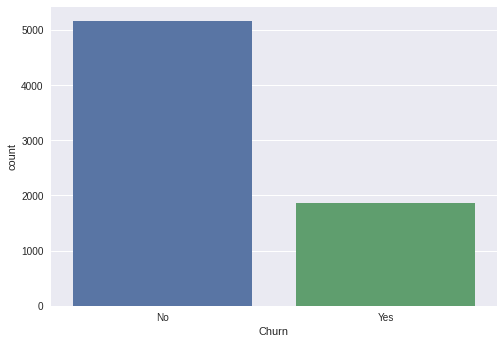

In [12]:
sns.countplot(x='Churn', data=df)

In [13]:
def percentage_stacked_plot(columns_to_plot):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
 
    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
  
        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0)

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.62, 0.62, 0.62),
                  title='Churn', fancybox=True)


        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

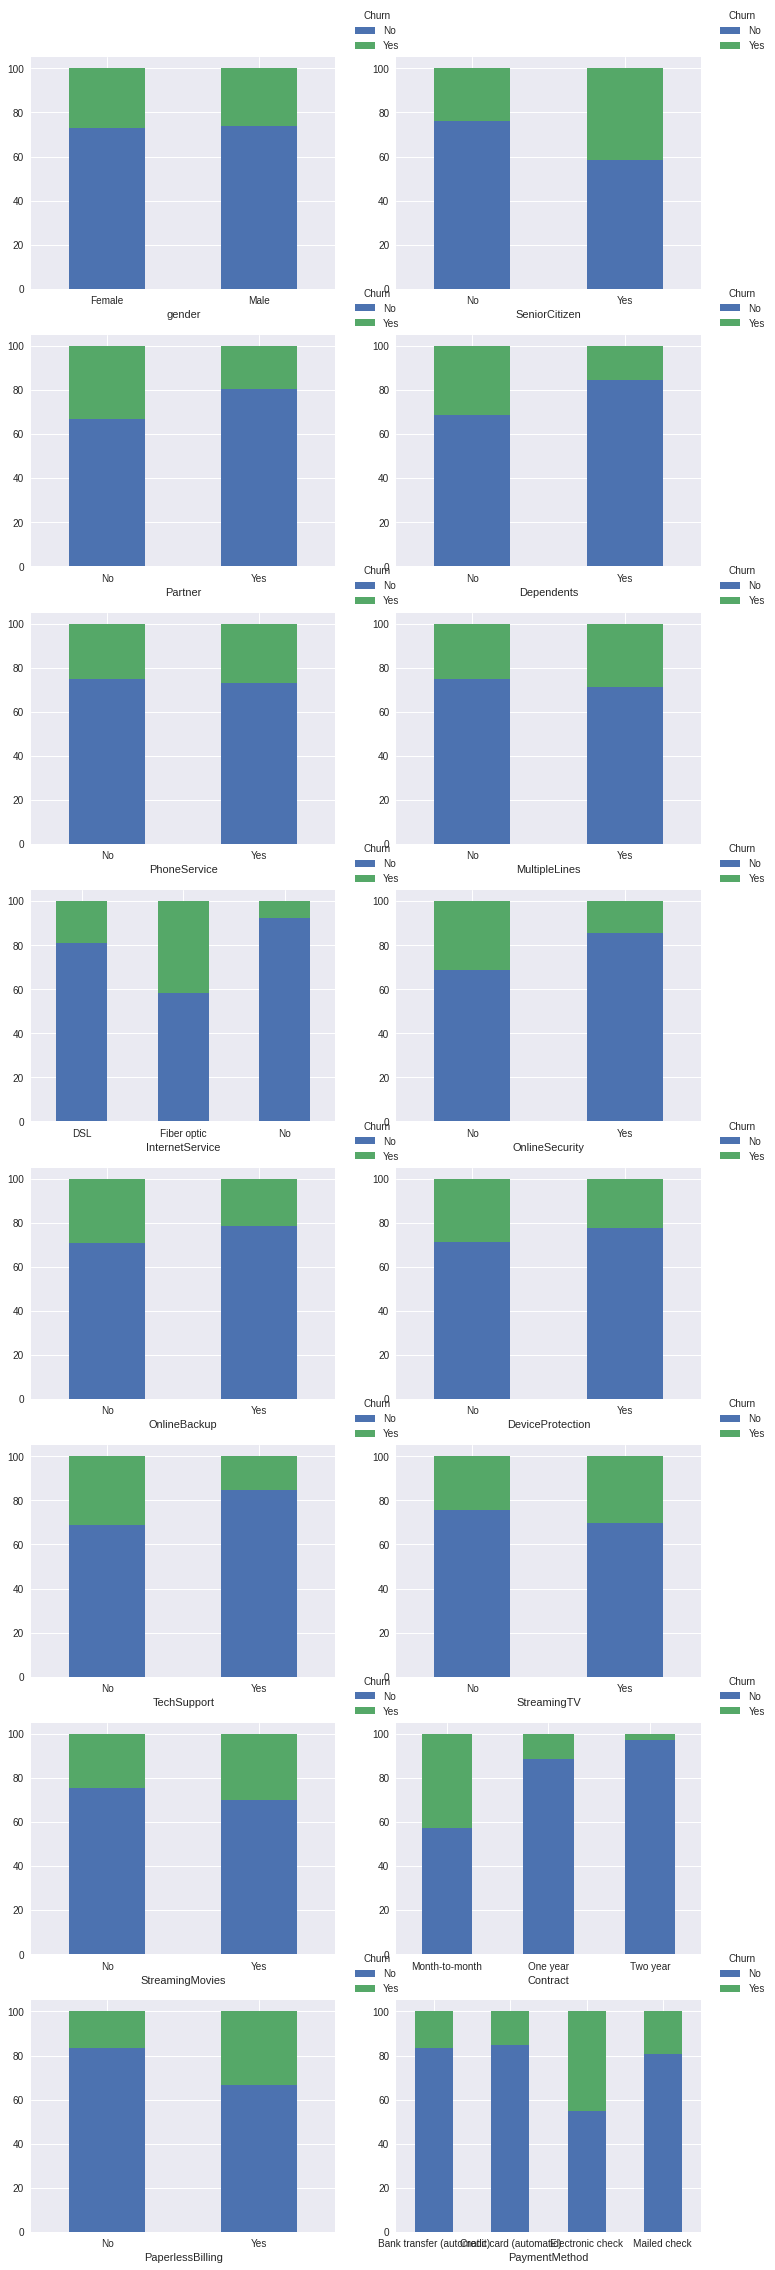

In [14]:
# demographic column names
column_object = [x for x in df.columns if df[x].dtype == 'object']
column_object.remove('Churn')
column_numerical = [x for x in df.columns if df[x].dtype != 'object']
# stacked plot of demographic columns
percentage_stacked_plot(column_object)

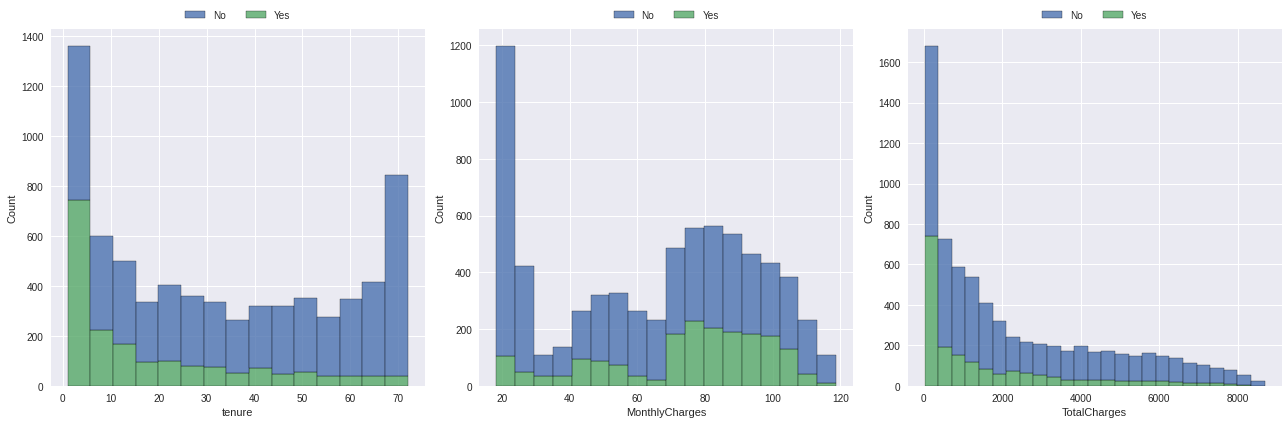

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

for i, col in enumerate(column_numerical):
  sns.histplot(data=df, x=col, hue='Churn', multiple='stack', ax=ax[i], alpha=0.8)
  sns.move_legend(ax[i], "lower center", bbox_to_anchor=(0.5, 1), ncol=3, title='', frameon=False)

plt.tight_layout()
sns.despine()
plt.show()

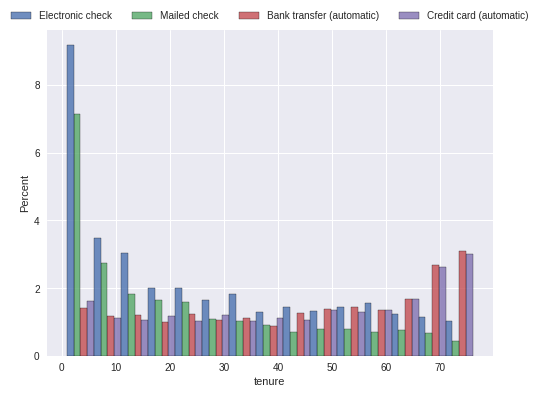

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df, x='tenure', hue='PaymentMethod', stat='percent', multiple='dodge', ax=ax, binwidth=5, alpha=0.8)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=4, title='', frameon=False)

sns.despine()  
plt.show()

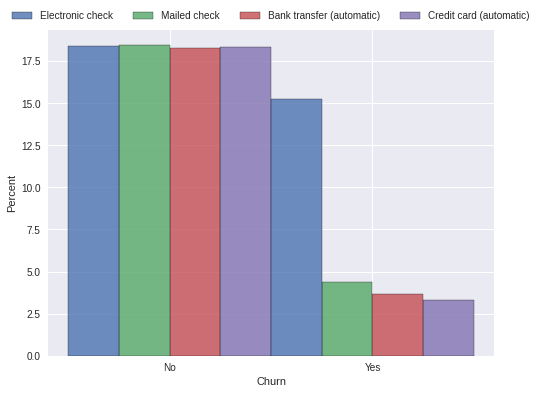

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df, x='Churn', hue='PaymentMethod', stat='percent', multiple='dodge', ax=ax, binwidth=1, alpha=0.8 )
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=4, title='', frameon=False )

sns.despine()  
plt.show()

###  Data Preprocessing

### Encoding categorical values
> for features that have more than 2 value types will use label encoding
 for the rest of the categorical features will use one hot encoding.

In [18]:
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'SeniorCitizen','PhoneService', 'Churn']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    if column == 'gender':
        df[column] = df[column].map({'Female': 1, 'Male': 0})
    else: 
        df[column] = df[column].map({'Yes': 1, 'No': 0}) 

In [19]:
df = pd.get_dummies(df, columns = [x for x in df.columns if df[x].dtype == 'object'] )

### Highly Correlated Columns
> Correlated columns can slow down training, lead to less interpretable models, and decrease generalization performance. So we will be  removing one of each pair of highly correlated columns.


In [20]:
# identify columns that exceed an absolute magnitude correlation of 0.95
threshold = 0.95

# Calculate correlations
corr_matrix = df.corr().abs()

# Subset to the upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Identify names of columns with correlation above threshold
to_drop = [column for column in upper.columns if any(
    upper[column] >= threshold)]

#print(f'There are {len(to_drop)} columns to drop with correlation > {threshold}')

# Remove highly correlated columns
df.drop(columns=to_drop, inplace=True)
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


(7032, 27)

# Modeling

### Train Test Split

In [21]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X = StandardScaler().fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1234, stratify=y)

In [23]:
print('X shape\t:', X.shape)
print('y shape\t:', y.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape\t:', X_test.shape)
print('y_test shape\t:', y_test.shape)


X shape	: (7032, 26)
y shape	: (7032,)

X_train shape	: (5625, 26)
y_train shape	: (5625,)

X_test shape	: (1407, 26)
y_test shape	: (1407,)


### Building baseline models

In [24]:
# baseline models:
r=1234
models = [LogisticRegression(random_state=r), GaussianNB(), KNeighborsClassifier(),
          SVC(random_state=r,probability=True), DecisionTreeClassifier(random_state=r),
          RandomForestClassifier(random_state=r), XGBClassifier(random_state=r)]

names = ["LogisticRegression","GaussianNB","KNN",
          "SVC","DecisionTree","Random_Forest","XGBoost"]

In [25]:
def model_report(names,model, X_train, X_test, y_train, y_test):
    print('baseline models validation accuracies for the train data:', end = "\n\n")
    for name, model in zip(names, models):
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      print("________________________________")
      print(name,"Model:")
      clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
      print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
      print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
      print(f"CLASSIFICATION REPORT:\n{clf_report}")
      print("________________________________")

model_report(names,models, X_train, X_test, y_train, y_test)

baseline models validation accuracies for the train data:

________________________________
LogisticRegression Model:
CONFUSION MATRIX:
[[927 106]
 [191 183]]
ACCURACY SCORE:
0.7889
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.829159    0.633218  0.788913     0.731189      0.777075
recall        0.897386    0.489305  0.788913     0.693346      0.788913
f1-score      0.861925    0.552036  0.788913     0.706980      0.779552
support    1033.000000  374.000000  0.788913  1407.000000   1407.000000
________________________________
________________________________
GaussianNB Model:
CONFUSION MATRIX:
[[767 266]
 [ 97 277]]
ACCURACY SCORE:
0.7420
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.887731    0.510129  0.742004     0.698930      0.787360
recall        0.742498    0.740642  0.742004     0.741570      0.742004
f1-score      0.808645    0.604144  0.742004    

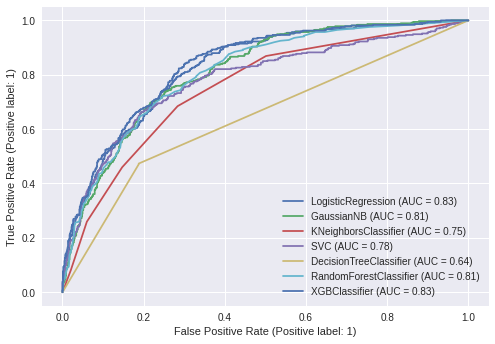

In [26]:
ax = plt.gca()
for model in models:
    plot_roc_curve(model, X_test, y_test, ax=ax)

As you can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.
Hence, we checked recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score are too low for Class 1 [churned customers].
Hence, we will use SMOTE and Edited Nearest Neighbor (SMOTE-ENN) method to overcome imbalanced datasets.

### Imbalanced datasets

In [27]:
smt = SMOTEENN(random_state=1234)
X1, y1 = smt.fit_resample(X, y)

In [28]:
X1.shape

(6367, 26)

In [29]:
y1.shape

(6367,)

In [30]:
xr_train,xr_test,yr_train,yr_test = train_test_split(X1, y1,test_size=0.2, random_state=1234)

In [31]:
# top 3 models:
r=1234
models_re = [LogisticRegression(random_state=r), RandomForestClassifier(random_state=r), XGBClassifier(random_state=r)]

names_re = ["LogisticRegression_re","Random_Forest_re","XGBoost_re"]

In [32]:
def resampled_model_report(names,model, X_train, X_test, y_train, y_test):
    print('model validation accuracies for the train data:', end = "\n\n")
    for name, model in zip(names, models):
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      print("________________________________")
      print(name,"Model:")
      clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
      print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred)}")
      print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")
      print(f"CLASSIFICATION REPORT:\n{clf_report}")
      print("________________________________")

model_report(names_re,models_re, xr_train, xr_test, yr_train, yr_test)

baseline models validation accuracies for the train data:

________________________________
LogisticRegression_re Model:
CONFUSION MATRIX:
[[537  59]
 [ 52 626]]
ACCURACY SCORE:
0.9129
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.911715    0.913869  0.912873     0.912792      0.912861
recall       0.901007    0.923304  0.912873     0.912155      0.912873
f1-score     0.906329    0.918562  0.912873     0.912446      0.912839
support    596.000000  678.000000  0.912873  1274.000000   1274.000000
________________________________
________________________________
Random_Forest_re Model:
CONFUSION MATRIX:
[[539  57]
 [ 73 605]]
ACCURACY SCORE:
0.8980
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.880719    0.913897  0.897959     0.897308      0.898376
recall       0.904362    0.892330  0.897959     0.898346      0.897959
f1-score     0.892384    0.902985  0.897959    

### Final model

In [33]:
model = XGBClassifier(random_state=1234)
model.fit(xr_train, yr_train)
y_pred = model.predict(xr_test)
clf_report = pd.DataFrame(classification_report(yr_test, y_pred, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(yr_test, y_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(yr_test, y_pred):.4f}")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

CONFUSION MATRIX:
[[557  39]
 [ 35 643]]
ACCURACY SCORE:
0.9419
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.940878    0.942815  0.941915     0.941847      0.941909
recall       0.934564    0.948378  0.941915     0.941471      0.941915
f1-score     0.937710    0.945588  0.941915     0.941649      0.941903
support    596.000000  678.000000  0.941915  1274.000000   1274.000000


In [34]:
import pickle
file = open('Customer_Churn_Prediction.pkl', 'wb')
pickle.dump(model, file)